In [17]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import random


In [18]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [19]:
path = 'plant_segmentation/dataset/arabidopsis/*/*'
imagepath = 'plant_segmentation/dataset/arabidopsis/images/*'
maskspath = 'plant_segmentation/dataset/arabidopsis/masks/'

In [20]:
heigh = 256

In [21]:
#get name of image to find mask for it
def get_mask(image):
   return tf.strings.split(image,os.path.sep)[-1]

#load images and masks from path
def process_image_with_mask(file_path):
      img = tf.io.read_file(file_path)
      img = tf.image.decode_png(img)
      mask = maskspath + get_mask(file_path)
      mask = tf.io.read_file(mask)
      mask = tf.image.decode_png(mask)
      return img,mask

#load images without masks from path
def process_image(file_path):
   img = tf.io.read_file(file_path)
   img = tf.image.decode_png(img)
   img = tf.image.resize(img, (heigh, heigh), method="nearest")
   img = tf.cast(img, np.float32) / 255.0
   img = img[:,:,:3]
   print(img.shape)
   return img

#resize to heigh
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (heigh, heigh), method="nearest")
   input_mask = tf.image.resize(input_mask, (heigh, heigh), method="nearest")
   return input_image, input_mask

#augmentation 1
def flip_leftright(input_image, input_mask):
   input_image = tf.image.flip_left_right(input_image)
   input_mask = tf.image.flip_left_right(input_mask)
   return input_image, input_mask

#augmentation 2
def flip_updown(input_image, input_mask):
   input_image = tf.image.flip_up_down(input_image)
   input_mask = tf.image.flip_up_down(input_mask)
   return input_image, input_mask

#augmentation 3
def rotation(input_image, input_mask):
   input_image = tf.image.rot90(input_image)
   input_mask = tf.image.rot90(input_mask)
   return input_image, input_mask

#augmentation 4
def crop(input_image, input_mask):
   seed = random.random()*10000
   input_image = tf.image.random_crop(input_image,size = (heigh*4,heigh*4,3),seed=int(seed))
   input_mask = tf.image.random_crop(input_mask,size = (heigh*4,heigh*4,1),seed=int(seed))
   return input_image, input_mask

#normalize mask and image
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, np.float32) / 255.0
   input_mask = tf.cast(input_mask, np.int16)
   return input_image, input_mask

def tf_dataset(imagepath,learning):
   dataset = tf.data.Dataset.list_files(imagepath)
   if learning:
      dataset = dataset.map(process_image_with_mask)
      datasetaugment = dataset.map(flip_leftright)
      dataset = dataset.concatenate(datasetaugment)
      datasetaugment = dataset.map(flip_updown)
      dataset = dataset.concatenate(datasetaugment)
      datasetaugment = dataset.map(rotation)
      dataset = dataset.concatenate(datasetaugment)
      dataset = dataset.map(crop)
      dataset = dataset.map(resize)
      dataset = dataset.map(normalize)
      dataset = dataset.shuffle(128)
   else:
      dataset = dataset.map(process_image)
      dataset = dataset.batch(1)
   return dataset

In [22]:
dataset = tf_dataset(imagepath,learning = True)
dataset
valdataset = tf_dataset(imagepath,learning = True)
valdataset = valdataset.batch(4)

In [23]:
len(dataset)

128

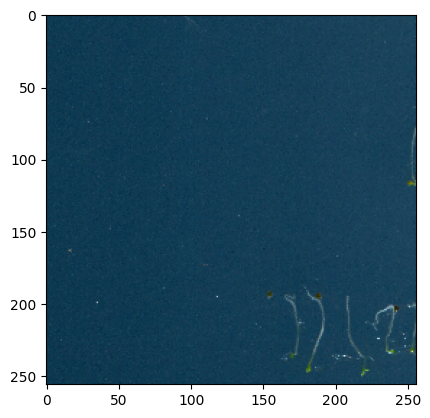

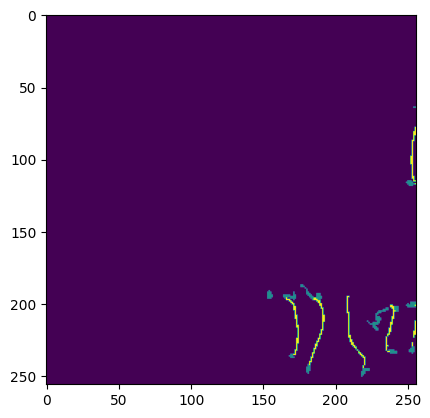

In [24]:
for image,mask in dataset.take(1):
        plt.imshow(tf.keras.utils.array_to_img(image))
        plt.pause(1)
        plt.imshow(tf.keras.utils.array_to_img(mask))

In [38]:
#unet
#encoder x:
def encoder_x(x,n_filters):
    x = tf.keras.layers.Conv2D(n_filters, 3, strides= 2,padding = "same", kernel_initializer = "he_normal",use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    skip = x
    return x,skip

#decoder_x:
def decoder_x(x,skip_connections,n_filters):
    x = tf.keras.layers.concatenate([x,skip_connections])
    x = tf.keras.layers.Conv2DTranspose(n_filters, 3, strides= 2,padding = "same", kernel_initializer = "he_normal",use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.ReLU()(x)
    return x

#output
def output(x):
    return tf.keras.layers.Conv2DTranspose(1,3, strides= 2,padding = "same", kernel_initializer = "he_normal",use_bias=False,activation='sigmoid')(x)


def buildmodel():
    inputlayer = tf.keras.layers.Input(shape=(256,256,3))
    print(inputlayer)
    e1,s1 = encoder_x(inputlayer,64)
    print(e1)
    e2,s2 = encoder_x(e1,128)
    e3,s3 = encoder_x(e2,256)
    e4,s4 = encoder_x(e3,512)
    e5,s5 = encoder_x(e4,512)
    e6,s6 = encoder_x(e5,512)
    e7,s7 = encoder_x(e6,512)
    d1 = decoder_x(e7,s7,512)
    d2 = decoder_x(d1,s6,512)
    d3 = decoder_x(d2,s5,512)
    d4 = decoder_x(d3,s4,256)
    d5 = decoder_x(d4,s3,128)
    d6 = decoder_x(d5,s2,64)
    d7 = tf.keras.layers.concatenate([d6,s1])
    outputlayer = output(d7)
    print(outputlayer)
    
    unet_model = tf.keras.Model(inputlayer, outputlayer, name="U-Net")

    unet_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = 'accuracy')

    return unet_model

model = buildmodel()


KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_21'), name='input_21', description="created by layer 'input_21'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 64), dtype=tf.float32, name=None), name='leaky_re_lu_87/LeakyRelu:0', description="created by layer 'leaky_re_lu_87'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), name='conv2d_transpose_96/Sigmoid:0', description="created by layer 'conv2d_transpose_96'")


In [39]:
model_history = model.fit(dataset.batch(4).repeat(),
                              epochs=8,
                              steps_per_epoch=16,
                              validation_data=valdataset,
                              validation_steps=4)

Epoch 1/8
16/16 [==============================] - ETA: 0s - loss: 0.8572 - accuracy: 0.7204

KeyboardInterrupt: 

In [ ]:
test = tf_dataset('cropped/AAE_0084.png',learning=False)
test

(256, 256, None)


<BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None)>

In [ ]:
pred_mask = model.predict(test)

1/1 [==============================] - 0s 218ms/step


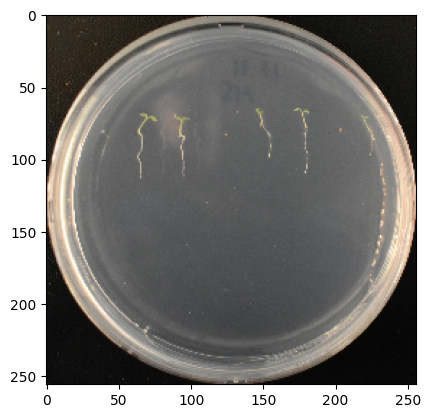

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


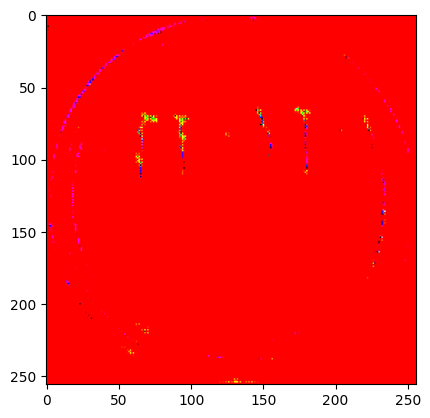

In [ ]:
for i,image in enumerate(test.take(120)):
    plt.imshow(tf.keras.utils.array_to_img(image[0]))
    plt.pause(1)
    plt.imshow(pred_mask[i,:,:,:])

In [ ]:
pred_mask.shape

(1, 256, 256, 3)